In [1]:
%matplotlib inline
import sys, os, glob
import subprocess

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate

from astropy.table import Table, join, vstack
import shutil

import astropy.units as u

from SEDmodel import SED

In [2]:
import scienceplots

plt.style.use([ 'bright', 'science', 'no-latex', 'notebook'])

In [3]:
m = 1e2

nu_min = 1e4          # minimum frequency, in Hz
nu_max = 1e22         # maximum frequency, in Hz

# generate SED
nu = 10.0**np.linspace(np.log10(nu_min),np.log10(nu_max),1000)
dnu = np.diff(nu)

mask_xray = (nu[:-1]*u.Hz > (2*u.keV).to(u.Hz, equivalencies=u.spectral())) & (nu[:-1]*u.Hz < (10*u.keV).to(u.Hz, equivalencies=u.spectral()))
Mdot_model = np.logspace(-12, -6, 10)*u.Msun/u.yr

L_X_RIAF_model = np.zeros(len(Mdot_model))*u.erg/u.s

# Calculate RIAF SED
for i, Mdoti in enumerate(Mdot_model.value):
    
    MdotEdd = 2.2*1e-8*m # u.Msun/u.yr

    # Eddington limit
    #if Mdoti/MdotEdd < 0.1:
        
    #L_X_REAF[i] = (eta*Mdot[i]*const.c**2).to(u.erg/u.s) # For radiatively efficient accretion

    Lnu, nu_p, Te0, Lnu_synch, Lnu_compt, Lnu_brems = SED(nu,m,Mdoti,verbose_return=True)
    L_X_RIAF_model[i] = np.sum((Lnu[:-1]*dnu)[mask_xray])*u.erg/u.s # I think (DOUBLE CHECK)

Electron temperature is 71.49 GK.
Electron temperature is 71.49 GK.
Electron temperature is 71.49 GK.
Electron temperature is 71.49 GK.
Electron temperature is 71.49 GK.
Electron temperature is 71.49 GK.
Electron temperature is 71.49 GK.
Electron temperature is 68.26 GK.
Electron temperature is 65.17 GK.
Electron temperature is 47.14 GK.


In [4]:
import numpy as np
import emcee

def log_prob(theta):
    if theta[0] < -12 or theta[0] > -4:
        return -np.inf
    if theta[1] < 0 or theta[1] > 12: # At least one source
        return -np.inf
    
    x, y_model = logN_logS(1e6*u.Msun, 10**theta[0]*u.Msun/u.yr, 10**theta[1])
    y = np.log10(9.2*((10**x)*285/1e-11)**-0.79)
        
    # equally likely as long as all model are below the data
    #if np.all(y - y_model) > 0: # data above model 
    #    return np.inf
    #else:

    dy  = y - y_model
    #dy = dy[np.isfinite(dy)]
    
    #plt.plot(x, y_model, color='gray');
    #plt.plot(x, y, lw=2)
    #plt.title( -0.5 * np.sum(dy**2))
    #plt.show()
    
    dys = np.zeros_like(y) # below data, likelihood is zero (equally likely)
    dys[dy<0] = dy[dy<0] # above data, start contiubing to likeilood
    
    return -0.5 * np.sum(dys**2/0.01)

def logN_logS(M_BH=1e6*u.Msun, Mdot=1e-6*u.Msun/u.yr, N=1e4):
    
        N_sim = 1e4
        
        # https://arxiv.org/pdf/1301.1341.pdf
        # https://arxiv.org/pdf/1612.00457.pdf
        
        # Change based on BH mass
        #eta = 0.01 # 
        #L_X = 0.1 * eta * Mdot * const.c**2
        L_X = np.interp(Mdot, Mdot_model, L_X_RIAF_model)

        # Plane centered on observer
        h_MW = 0.5*u.kpc
        r_MW = 10*u.kpc
        V_MW = 2*np.pi*r_MW**2*h_MW
        
        d_MW_rand = np.random.uniform(-r_MW.value, r_MW.value, int(N_sim))*u.kpc
        h_MW_rand = np.random.uniform(-h_MW.value, h_MW.value, int(N_sim))*u.kpc

        #h_MW_rand = np.random.normal(0, h_MW.value, N)*u.kpc
        # Assume centered around the observer
        d_L_rand = np.sqrt((0*u.kpc)**2 + d_MW_rand**2 + h_MW_rand**2)

        S_X = L_X/(4*np.pi*d_L_rand**2)
        S_X = S_X.to(u.erg/u.s/u.cm**2)
        
        # log N - log S
        _logS_X = np.log10(S_X.value)

        fbins = np.linspace(np.min(_logS_X), np.max(_logS_X), 20)
        Nbin = np.zeros(len(fbins))
        
        for i, b in enumerate(fbins):
            Nbin[i] = len(_logS_X[_logS_X > b])
            # is this right?
        Nbin = Nbin*N/N_sim
        #if i > 0:
        #    Nbin[i] += (Nbin[i-1]*N/N_sim) #/len(fbins)
                          
                          
        #Nbin = [len(_logS_X[_logS_X > b]) for b in fbins]
        #Nbin = [Nbin[i-1]/N_sim/len(fbins) for i in len(Nbin)]
            
        return fbins, np.log10(Nbin) #*N/N_sim # this is incorrect i think, need to rescale as cumulative 
    

In [5]:
ndim, nwalkers = 2, 12
p0 = np.array([np.random.uniform(-12, -6, nwalkers), np.random.uniform(3, 6, nwalkers)]).T

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
state = sampler.run_mcmc(p0, 3000, skip_initial_state_check=True)

In [6]:
flat_samples = sampler.get_chain(flat=True)
print(flat_samples.shape)

(36000, 2)


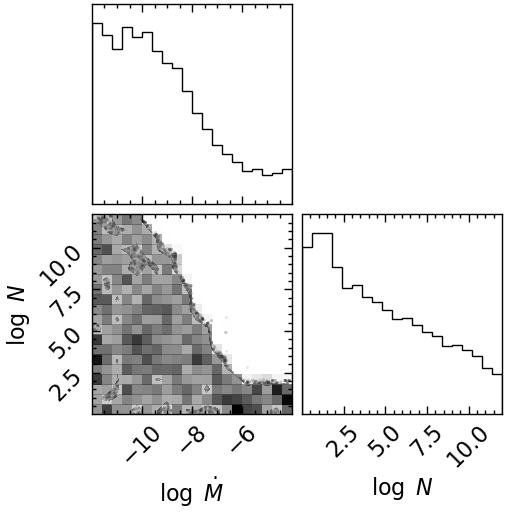

In [7]:
import corner
labels = [r'$\log\ \dot{M}$', r'$\log\ N$']
fig = corner.corner(flat_samples, labels=labels, plot_contours=False);

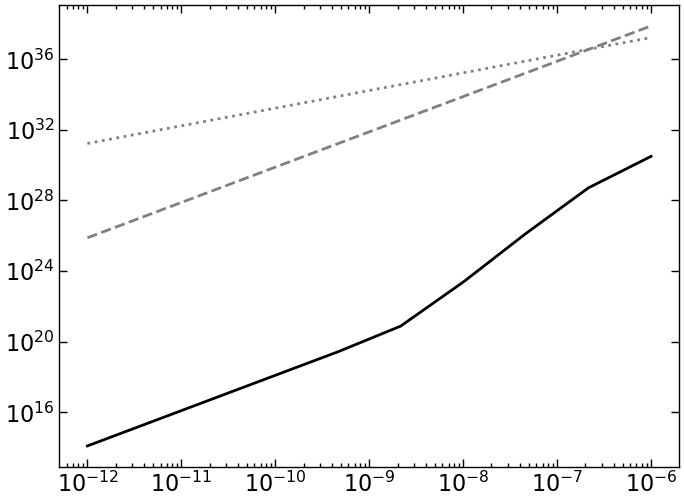

In [11]:
Mdot = Mdot_model #.value

plt.loglog(Mdot, L_X_RIAF_model.to(u.erg/u.s), color='k')

Mdot_Edd = 2.2*1e-8*(m)*u.Msun/u.yr # 0.1 L_Edd/c^2
Mdot_crit = 0.1*Mdot_Edd
#Mdot_crit = 1e13*(1.1*1e17*u.g/u.s).to(u.Msun/u.yr)
eta = 0.01*Mdot/Mdot_crit # ADAF
L = eta * Mdot * const.c**2
plt.loglog(Mdot, (0.03*L).to(u.erg/u.s), color='gray', linestyle='dashed')

eta = 0.01 # 
L = eta * Mdot * const.c**2
plt.loglog(Mdot, (0.03*L).to(u.erg/u.s), color='gray', linestyle='dotted')